Let's use the example of a [custom “add n” model](https://www.mlflow.org/docs/latest/models.html#id37) provided in `mlflow.pyfunc` [documentation](https://www.mlflow.org/docs/latest/models.html#id37).

In [1]:
from pathlib import Path
from whylogs.viz import ProfileVisualizer
import mlflow.pyfunc
import pandas as pd
import glob
from whylogs import DatasetProfile
import numpy as np
import requests


In [2]:
# Code largely copied from https://www.mlflow.org/docs/latest/models.html#example-creating-a-custom-add-n-model

# Define the model class
class AddN(mlflow.pyfunc.PythonModel):

    def __init__(self, n):
        import atexit
        import whylogs

        self.n = n
        ylog_sess = whylogs.get_or_create_session(".whylogs.yaml")
        self.ylog = ylog_sess.logger("live", with_rotation_time="m")

        atexit.register(self.ylog.close)

    def predict(self, context, model_input):
        self.ylog.log_dataframe(model_input)
        return model_input + self.n

In [3]:
# Construct and save the model
add5_model = AddN(n=5)
artifact_path = "add_n_model"
mlflow.pyfunc.log_model(python_model=add5_model, artifact_path=artifact_path, conda_env="./conda.yml")
artifact_uri = mlflow.active_run().info.artifact_uri
assert artifact_uri.startswith("file://")
model_uri = str(Path(artifact_uri[len("file://"):]) / artifact_path)
model_uri

'/home/congvc2/s/mlflow_whylogs/mlruns/0/f1b28fc369794fa3a65ffc6974b47080/artifacts/add_n_model'

In [4]:
# Load the model in `python_function` format
loaded_model = mlflow.pyfunc.load_model(model_uri)

In [5]:
# Evaluate the model
n_rows = 5
model_input = pd.DataFrame(np.random.randint(95, size=(n_rows,4)))
model_input.columns = ["Usee Sales", "Demand Forcast Sales", "FJP.ABC Sales", "FJP Sales"]
display(model_input)

model_output = loaded_model.predict(model_input)
display(model_output)
assert model_output.equals(model_input+5)


,Usee Sales,Demand Forcast Sales,FJP.ABC Sales,FJP Sales
0,53,40,86,30
1,94,82,83,55
2,6,84,32,87
3,21,86,9,12
4,2,4,7,89


,Usee Sales,Demand Forcast Sales,FJP.ABC Sales,FJP Sales
0,58,45,91,35
1,99,87,88,60
2,11,89,37,92
3,26,91,14,17
4,7,9,12,94


In [51]:
# Use MLflow serving
n_rows = 1_000
model_input = pd.DataFrame(np.random.randint(999999, size=(n_rows,4)))
model_input.columns = ["Usee Sales", "Demand Forcast Sales", "FJP.ABC Sales", "FJP"]
api_output = requests.post(
        "http://127.0.0.1:5001/invocations",
        data=model_input.to_json(orient="split", index=False),
        headers={"Content-type": "application/json"},
)
# profile_binaries = glob.glob('output/live/**/*.bin', recursive=True)
profile_binaries = glob.glob('/tmp/whylogs-output/live/**/*.bin', recursive=True)
profile_binaries
profiles = [DatasetProfile.read_protobuf(x, delimited_file=False) for x in profile_binaries]
len(profiles), profiles

(5,
  <whylogs.core.datasetprofile.DatasetProfile at 0x7f723366f048>])

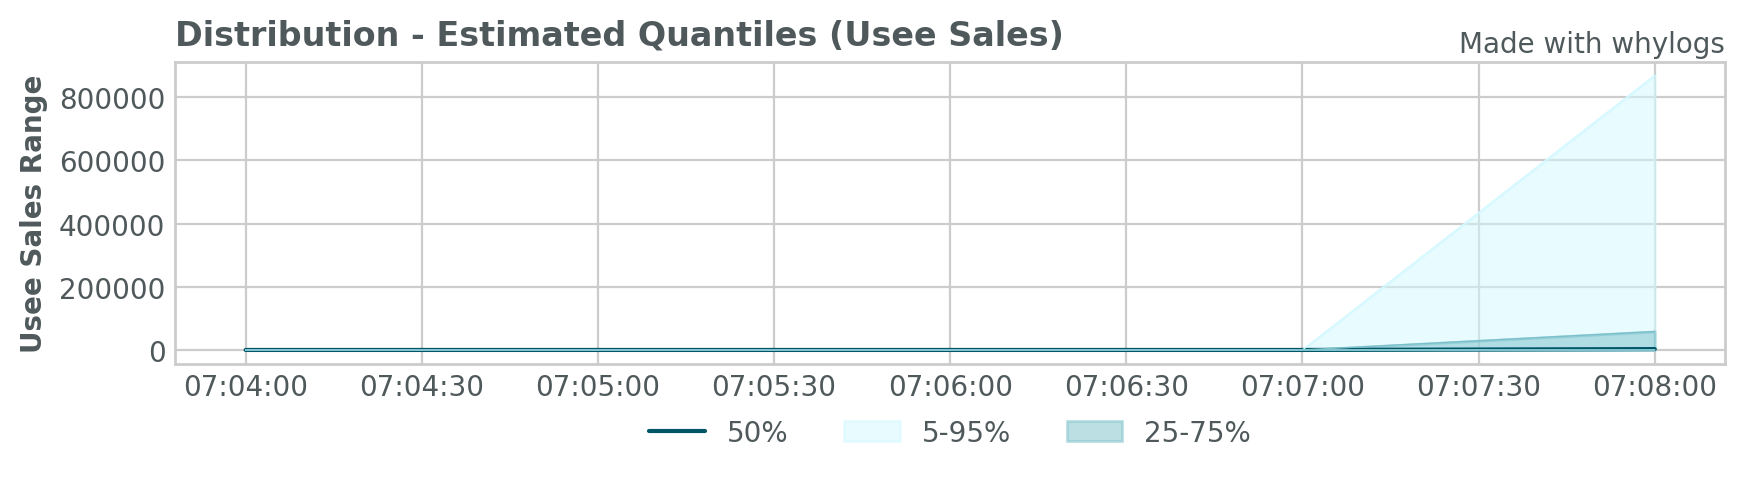

In [50]:
viz = ProfileVisualizer()
viz.set_profiles(profiles)
viz.plot_distribution("Usee Sales", ts_format="%H:%M:%S")
# viz.plot_distribution("FJP", ts_format="%H:%M:%S")